In [544]:
## IMPORT 

import os
import numpy as np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt, resample, savgol_filter
from scipy.stats import linregress, ttest_ind, pearsonr
from scipy.optimize import curve_fit, minimize
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib as mpl
import h5py
from pathlib import Path
import glob
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.integrate import simpson
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator
from scipy.stats import wilcoxon


In [545]:
# Text 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140


In [546]:
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/'

# Find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, "*.csv"))

# Initialize list to store df
df = pd.DataFrame()

# Loop through each CSV, then concatenate them into a single df
for file in csv_files:
    single = pd.read_csv(file)
    df = pd.concat([df, single], axis=0, ignore_index=True)

df

,Time,Zscoreg,Zscorer,In black,In grey,In white,In last,ID,sex
0,0.097857,0.216460,0.023744,1,0,0,0,1034,M
1,0.114533,0.216460,0.023744,1,0,0,0,1034,M
2,0.131209,0.216460,0.023744,1,0,0,0,1034,M
3,0.147885,0.216460,0.023744,1,0,0,0,1034,M
4,0.164561,0.216460,0.023744,1,0,0,0,1034,M
...,...,...,...,...,...,...,...,...,...
395925,600.129720,-0.184316,-1.527112,0,0,0,0,1045,F
395926,600.146394,-0.142347,-1.117805,0,0,0,0,1045,F
395927,600.163068,-0.109589,-0.485170,0,0,0,0,1045,F
395928,600.179741,-0.110086,0.598385,0,0,0,0,1045,F


In [547]:
# df = df[df['sex'] == 'F'].reset_index(drop=True)

In [548]:
polyorder = 2  # Polynomial order
window_length = 41  # Window length: must be an odd number

# Group by ID and day, then apply the Savitzky-Golay filter
df['Zscoreg'] = df.groupby(['ID'])['Zscoreg'].transform(lambda x: savgol_filter(x, window_length, polyorder))

## position signal correlation

In [549]:
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/ampos'

# Find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, "*.csv"))

# Initialize list to store df
dfpos = pd.DataFrame()

# Loop through each CSV, then concatenate them into a single df
for file in csv_files:

    name_parts = os.path.basename(file).split('_')
    mouse_id = name_parts[0]
    single = pd.read_csv(file)

    single['ID'] = mouse_id
    dfpos = pd.concat([dfpos, single], axis=0, ignore_index=True)

dfpos

,Time (s),Centre position X,Centre position Y,ID
0,0.000,NaN,NaN,1045
1,0.327,53.0,206.0,1045
2,0.471,53.0,206.0,1045
3,0.598,52.0,205.0,1045
4,0.727,52.0,206.0,1045
...,...,...,...,...
46451,599.393,170.0,211.0,1050
46452,599.521,170.0,211.0,1050
46453,599.665,169.0,211.0,1050
46454,599.793,169.0,211.0,1050


In [550]:
# Ensure 'ID' column in both dataframes has the same data type
dfpos['ID'] = dfpos['ID'].astype(int)

# Merge the dfpos and df dataframes on the 'ID' and 'Time' columns using nearest merge
dfpos = pd.merge_asof(
    dfpos.sort_values('Time (s)'), 
    df[['ID', 'Time', 'Zscoreg']].sort_values('Time'), 
    left_on='Time (s)', 
    right_on='Time', 
    by='ID', 
    direction='nearest'
)

# Drop the redundant 'Time' column from the merged dataframe
dfpos = dfpos.drop(columns=['Time (s)'])

# Display the updated dfpos dataframe
dfpos


,Centre position X,Centre position Y,ID,Time,Zscoreg
0,NaN,NaN,1045,0.089889,-1.273457
1,NaN,NaN,1034,0.097857,0.216460
2,NaN,NaN,116,0.085905,1.473977
3,NaN,NaN,1046,0.092047,1.200879
4,NaN,NaN,1035,0.083747,0.314368
...,...,...,...,...,...
46451,115.0,200.0,1045,599.946308,-0.251995
46452,62.0,194.0,118,599.946721,-0.738321
46453,166.0,206.0,1035,599.973514,0.109069
46454,195.0,192.0,1052,599.977657,1.394112


In [551]:
#scale x position to maxe dimensions in cm: 

dfpos['Centre position X'] = dfpos['Centre position X']*(1000/dfpos['Centre position X'].max())
print(dfpos['Centre position X'].max()*(1000/dfpos['Centre position X'].max()))

1000.0


In [552]:
# dfpos = dfpos[dfpos['Centre position X'] < 540]

      ID       maxbin
0   1045   553.921569
1   1034   787.581699
2    116   542.483660
3   1046   986.928105
4   1035   849.673203
5   1050  1000.000000
6   1052   986.928105
7   1028   973.856209
8    118   586.601307
9   1051   986.928105
10   129   566.993464


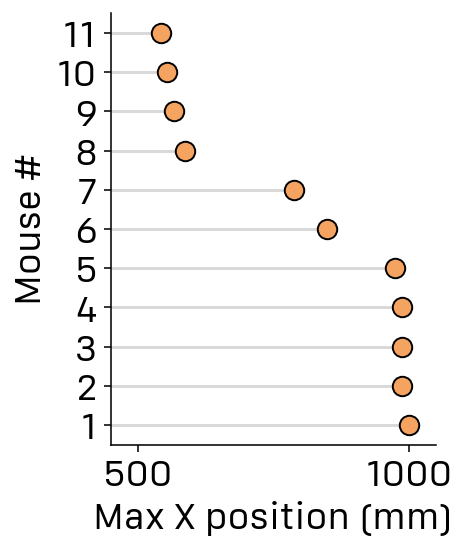

In [553]:
## bin histograms : 
maxvalue = {'ID':[], 'maxbin':[]}
for mouse in dfpos['ID'].unique():
    mousedata = dfpos[dfpos['ID'] == mouse]
    indxmax=mousedata['Centre position X'].max()
    maxvalue['ID'].append(mouse)
    maxvalue['maxbin'].append(indxmax)

maxvalue = pd.DataFrame(maxvalue)
print(maxvalue)
maxvalue = maxvalue.sort_values('maxbin', ascending=False).reset_index(drop=True)

plt.figure(figsize=(3, 4))


plt.scatter(maxvalue['maxbin'], maxvalue.index, alpha=1, color='sandybrown', s=100, edgecolor='black', zorder=1) 
for mouse in maxvalue['ID']:
    plt.hlines(y=maxvalue[maxvalue['ID'] == mouse].index[0], xmin=0, xmax=maxvalue[maxvalue['ID'] == mouse]['maxbin'].iloc[0], 
               colors='gray', alpha= 0.3,zorder=0)

plt.xlim(450,1050)
plt.yticks(ticks=maxvalue.index, labels=(maxvalue.index)+1)
plt.ylabel('Mouse #')
plt.xlabel('Max X position (mm)')
#plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/maxpositionid.pdf', format='pdf')
plt.show()


trak NOT subset; don't know how to subset; dropped


r value : 0.886862587618921, pvalue : 0.0002733782099940027, r squared : 0.7865252493181283


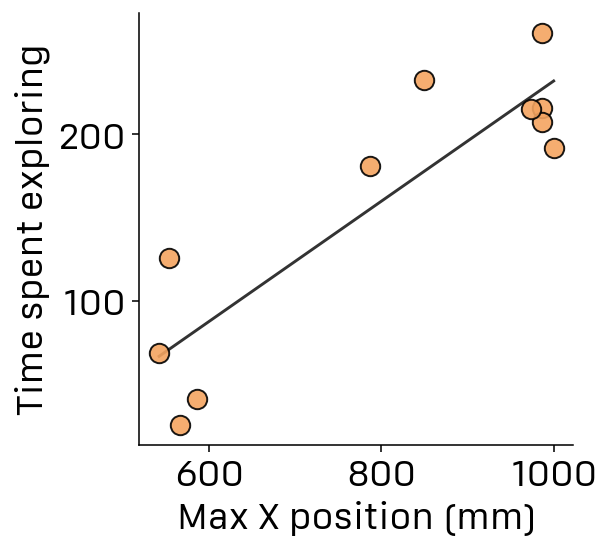

In [585]:
###max pos - time spent correlation

corr = {'ID':[], 'maxpos':[], 'timespent':[]}

for mouse in maxvalue['ID'].unique():
    mousedatamax = maxvalue[maxvalue['ID'] == mouse]
    maxpos = mousedatamax['maxbin']
    corr['ID'].append(mouse)
    corr['maxpos'].append(maxpos.iloc[0])
    timedf = df[df['ID'] == mouse]
    timepsentblack = len(timedf[timedf['In black'] == 1])/60
    explotime = 600 - timepsentblack
    corr['timespent'].append(explotime)

corr = pd.DataFrame(corr)

slope, intercept, r_value, p_value, std_err = linregress(corr['maxpos'], corr['timespent'])

plt.figure(figsize=(4, 4))

plt.plot(corr['maxpos'], intercept + slope * corr['maxpos'], color='black', alpha=0.8, zorder=0)
plt.scatter(corr['maxpos'], corr['timespent'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
print(f'r value : {r_value}, pvalue : {p_value}, r squared : {r_value**2}')
plt.xlabel('Max X position (mm)')
plt.ylabel('Time spent exploring')
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/corrMAXposTIMESPENT.pdf', format='pdf')
plt.show()




In [555]:
##### CORRELATION PLOOOT

# dfpos.dropna(inplace=True)

# # dfpos['Centre position X'] = dfpos.groupby('ID')['Centre position X'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# plt.scatter(dfpos['Centre position X'], dfpos['Zscoreg'], alpha=0.5, color='none', edgecolor='lightgray', s=5)
# # Fit line

# slope, intercept, r_value, p_value, std_err = linregress(dfpos['Centre position X'], dfpos['Zscoreg'])
# print(slope)
# plt.plot(dfpos['Centre position X'], intercept + slope * dfpos['Centre position X'], color='black', alpha=0.8)
# plt.show()
# print(r_value, p_value)


In [556]:
# #NORMALIZED SIGNAL PLOTS
# #### LOCATION VS SIGNAL ANALYSIS 
# dfpos.dropna(inplace=True)
# #dfpos['Zscoreg'] = dfpos.groupby('ID')['Zscoreg'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# correlation_results = {'ID': [], 'correlation': [], 'rsquared': []}

# plt.figure(figsize=(4, 4))
# # Loop through each unique ID

# for mouse_id in dfpos['ID'].unique():
#     # Filter data for the current mouse ID
#     mouse_data = dfpos[dfpos['ID'] == mouse_id]
    
#     # Calculate the correlation between Zscoreg and Centre position X
#     correlation, p_value = pearsonr(mouse_data['Zscoreg'], mouse_data['Centre position X'])
    
#     # Store the results
#     correlation_results['ID'].append(mouse_id)
#     correlation_results['correlation'].append(correlation)
#     plt.scatter(mouse_data['Zscoreg'], mouse_data['Centre position X'], alpha=0.5, color='none', edgecolor='lightgray', s=5)
    
#     # Fit line
#     slope, intercept, r_value, p_value, std_err = linregress(mouse_data['Zscoreg'], mouse_data['Centre position X'])
#     correlation_results['rsquared'].append(r_value**2)
   
#     plt.plot(mouse_data['Zscoreg'], intercept + slope * mouse_data['Zscoreg'], color='black', alpha=0.8)
    
#     plt.xlabel('Norm. z-scored Fluo.')
#     plt.ylabel('X location')
# #plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/poscorr.pdf', format='pdf')
# plt.show()

# # Display correlation results
# correlation_results
# print 
# ###### PERMUTATION 

# # Permutation test
# np.random.seed(42)  # For reproducibility
# n_permutations = 1000

# pcorrelation_results = {'ID': [], 'pcorrelation': [], 'prsquared': []}

# for mouse_id in dfpos['ID'].unique():
#     # Filter data for the current mouse ID
#     mouse_data = dfpos[dfpos['ID'] == mouse_id]
    
#     for _ in range(n_permutations):
#         # Shuffle the Zscoreg values
#         mouse_data['pZscoreg'] = np.random.permutation(mouse_data['Zscoreg'])

#     pcorrelation, p_value = pearsonr(mouse_data['pZscoreg'], mouse_data['Centre position X'])
#     pcorrelation_results['ID'].append(mouse_id)
#     pcorrelation_results['pcorrelation'].append(pcorrelation)

#     slope, intercept, r_value, p_value, std_err = linregress(mouse_data['pZscoreg'], mouse_data['Centre position X'])
#     pcorrelation_results['prsquared'].append(r_value**2)

# # Convert correlation results to DataFrame
# correlation_df = pd.DataFrame(correlation_results)
# pcorrelation_df = pd.DataFrame(pcorrelation_results)

# permdf = pd.merge(correlation_df, pcorrelation_df, on='ID', suffixes=('_corr', '_pcorr'))

# #### CORRELATION (PEARSON R) PLOT

# print(permdf)

# t_stat, p_value = wilcoxon(permdf['correlation'], permdf['pcorrelation'])

# print(f"T-statistic: {t_stat}, P-value: {p_value}")


# plt.figure(figsize=(4, 5))

# conditions = ['data', 'shuffled']
# means = [permdf['correlation'].mean(), permdf['pcorrelation'].mean()]
# sems = [permdf['correlation'].sem(), permdf['pcorrelation'].sem()]
# plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
#             zorder=0)

# # Plot individual data points
# plt.scatter(np.repeat('data', len(permdf)), permdf['correlation'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
# plt.scatter(np.repeat('shuffled', len(permdf)), permdf['pcorrelation'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)

# plt.ylabel('correlation')
# plt.ylim(-0.15,1)
# ax = plt.gca()  # Get the current axis
# ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
# ax.set_xlim(-0.55,3-0.5)
# #plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/OF_FP/OF_BLA/figures/velocitybarplot.pdf', format='pdf')
# plt.show()

# ### R-Squared plot 
# plt.figure(figsize=(4, 5))

# # Plot rsquared vs prsquared
# conditions = ['data', 'shuffled']
# means = [permdf['rsquared'].mean(), permdf['prsquared'].mean()]
# sems = [permdf['rsquared'].sem(), permdf['prsquared'].sem()]
# plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
#             zorder=0)

# # Plot individual data points
# plt.scatter(np.repeat('data', len(permdf)), permdf['rsquared'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
# plt.scatter(np.repeat('shuffled', len(permdf)), permdf['prsquared'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)

# plt.ylabel('R-squared')
# plt.ylim(-0.15,1)
# ax = plt.gca()  # Get the current axis
# ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
# ax.set_xlim(-0.55,3-0.5)
# #plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/OF_FP/OF_BLA/figures/velocitybarplot.pdf', format='pdf')
# plt.show()


In [557]:
dfpos = dfpos.iloc[::5].reset_index(drop=True)
dfpos

,Centre position X,Centre position Y,ID,Time,Zscoreg
0,NaN,NaN,1045,0.089889,-1.273457
1,NaN,NaN,1050,0.087399,1.898725
2,NaN,NaN,129,0.085241,2.971143
3,89.869281,197.0,1034,0.364675,0.216460
4,94.771242,210.0,1035,0.467244,0.314368
...,...,...,...,...,...
9287,271.241830,206.0,1035,599.723407,0.269581
9288,186.274510,201.0,1045,599.796244,-0.228064
9289,387.254902,198.0,116,599.858955,0.211130
9290,197.712418,206.0,1034,599.937259,-1.595802


2.379636725350992
3.0984329301893827
1.9833012577461693
2.382090488407688
2.81322705648486
1.9113713998648085
1.9019883859641402
1.578472222304594
2.4104925949173497
1.697120458698369
1.7795233375458208


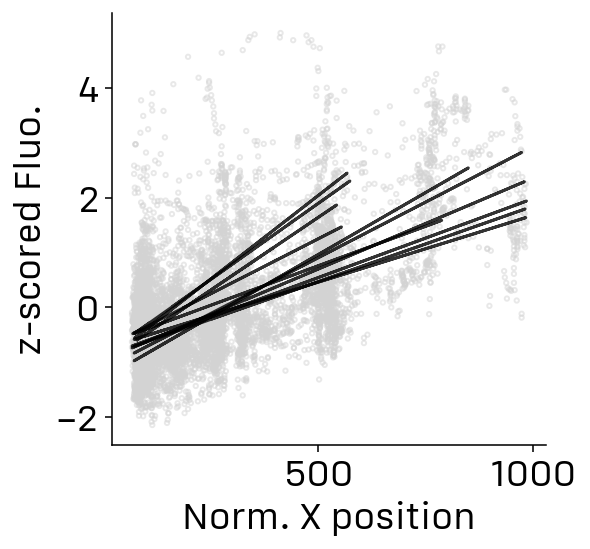

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_81622/100298439.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_data['pCentre position X'] = np.random.permutation(mouse_data['Centre position X'])
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_81622/100298439.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_data['pCentre position X'] = np.random.permutation(mouse_data['Centre position X'])
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_81622/100298439.p

      ID  correlation  rsquared     slope  slopenorm      maxpos  \
0   1034     0.557177  0.310446  0.164545  64.106877  787.581699   
1   1035     0.785889  0.617621  0.258329  74.115573  849.673203   
2   1052     0.685663  0.470134  0.164538  69.266939  985.294118   
3   1028     0.804473  0.647177  0.231760  74.698597  973.856209   
4    118     0.531575  0.282572  0.316707  70.168697  573.529412   
5   1045     0.540214  0.291831  0.228687  62.772670  553.921569   
6   1051     0.573982  0.329455  0.157216  68.213075  982.026144   
7    116     0.706639  0.499339  0.302769  67.954943  542.483660   
8    129     0.722112  0.521446  0.347795  71.595735  566.993464   
9   1050     0.766117  0.586935  0.189559  71.720401  980.392157   
10  1046     0.524631  0.275237  0.139125  65.730634  983.660131   

    10thquantilezscoregmean  pcorrelation  prsquared    pslope  
0                  3.070890      0.017130   0.000293  0.005059  
1                  3.687114      0.027009   0.000730 

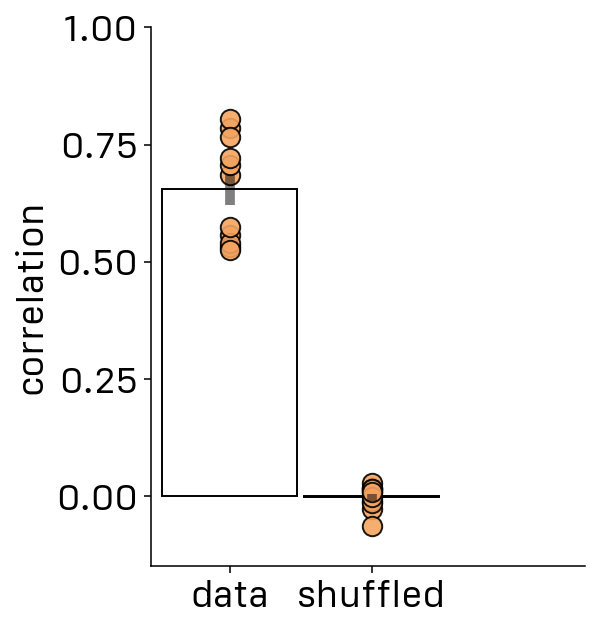

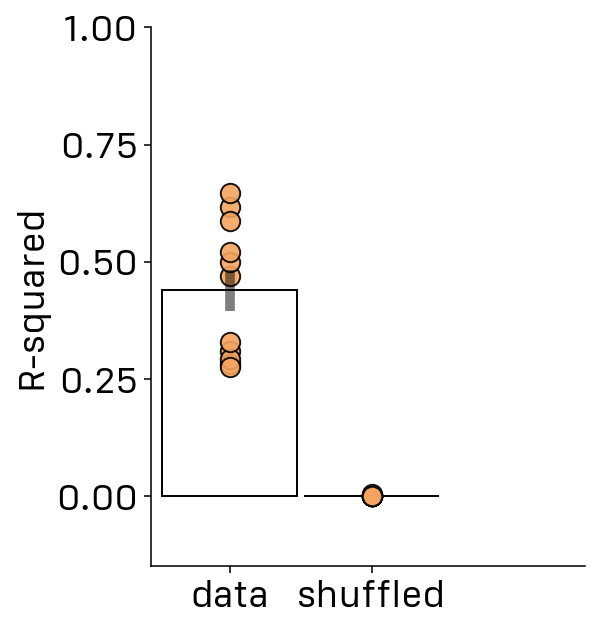

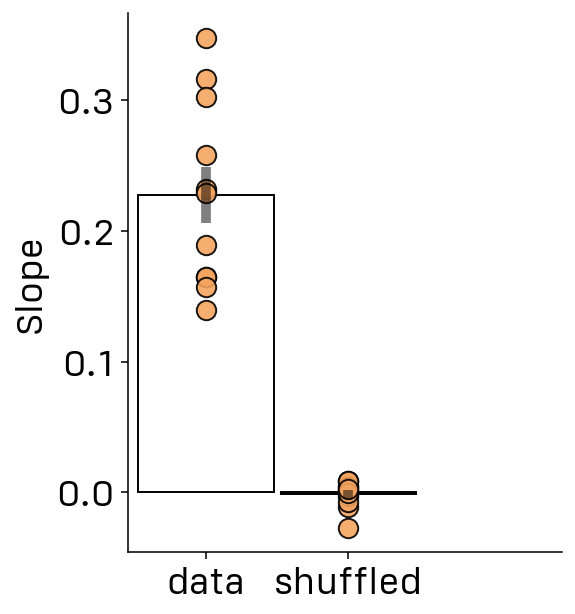

r value : -0.7864913617016119, pvalue : 0.004087508882740307, r squared : 0.6185686620312558


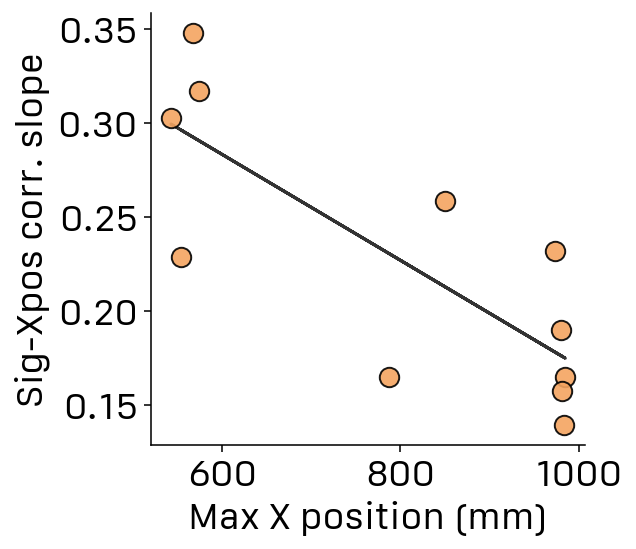

r value : -0.39438482236674, pvalue : 0.23003650697164318, r squared : 0.15553938811324505


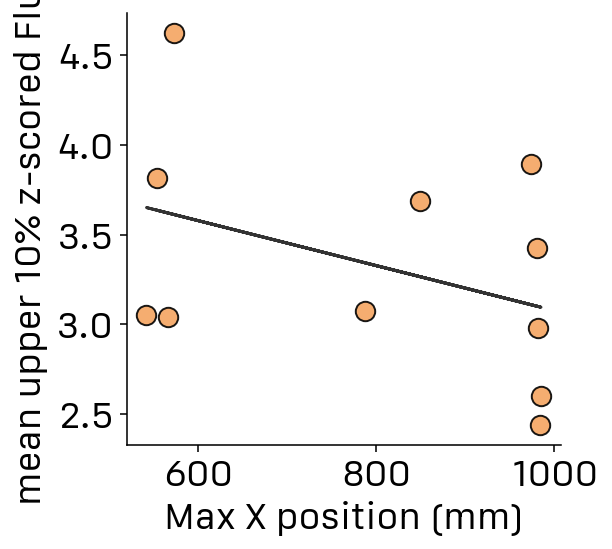

<Axes: xlabel='slope_zscore', ylabel='Count'>

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  func(*args, **kwargs)
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


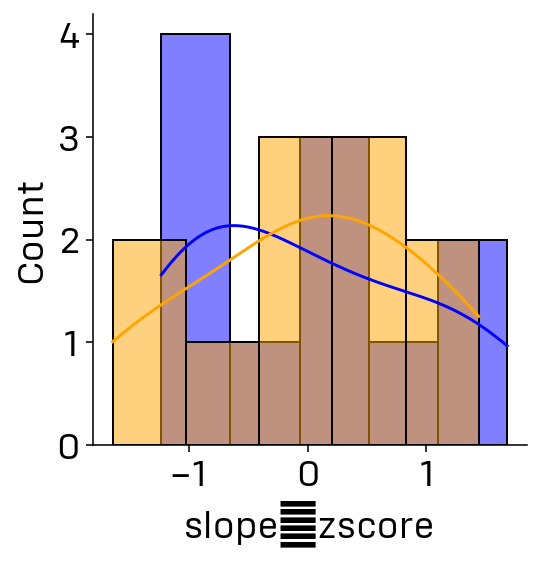

In [558]:
# NORMALIZED POSITION 
#### LOCATION VS SIGNAL ANALYSIS 
dfpos.dropna(inplace=True)
# dfpos['Centre position X'] = dfpos.groupby('ID')['Centre position X'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
dfpos['norm position X'] = dfpos.groupby('ID')['Centre position X'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

correlation_results = {'ID': [], 'correlation': [], 'rsquared': [], 'slope' : [], 'slopenorm': [], 'maxpos':[], '10thquantilezscoregmean':[]} 

plt.figure(figsize=(4, 4))
# Loop through each unique ID

for mouse_id in dfpos['ID'].unique():
    # Filter data for the current mouse ID
    mouse_data = dfpos[dfpos['ID'] == mouse_id]
    
    # Calculate the correlation between Centre position X and Zscoreg
    correlation, p_value = pearsonr(mouse_data['Centre position X'], mouse_data['Zscoreg'])
    
    # Store the results
    correlation_results['ID'].append(mouse_id)
    correlation_results['correlation'].append(correlation)
    correlation_results['maxpos'].append(mouse_data['Centre position X'].max())
    correlation_results['10thquantilezscoregmean'].append(mouse_data['Zscoreg'].quantile(0.99))
    # correlation_results['10thquantilezscoregmean'].append(mouse_data['Zscoreg'].quantile(0.9))
    print(mouse_data['Zscoreg'].quantile(0.95))
    plt.scatter(mouse_data['Centre position X'], mouse_data['Zscoreg'], alpha=0.5, color='none', edgecolor='lightgray', s=5)

    
    # Fit line
    slope, intercept, r_value, p_value, std_err = linregress(mouse_data['Centre position X'], mouse_data['Zscoreg'])
    slopenorm, _,_,_,_, = linregress(mouse_data['norm position X'], mouse_data['Zscoreg'])

    correlation_results['rsquared'].append(r_value**2)
    correlation_results['slope'].append(np.degrees(np.arctan(slope)))
    correlation_results['slopenorm'].append(np.degrees(np.arctan(slopenorm)))

    plt.plot(mouse_data['Centre position X'], intercept + slope * mouse_data['Centre position X'], color='black', alpha=0.8)
    
    plt.xlabel('Norm. X position')
    plt.ylabel('z-scored Fluo.')
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/nnormsigposcorr.pdf', format='pdf')
plt.show()

# Display correlation results
correlation_results
print 
###### PERMUTATION 

# Permutation test
np.random.seed(41)  # For reproducibility
n_permutations = 1000

pcorrelation_results = {'ID': [], 'pcorrelation': [], 'prsquared': [], 'pslope' : []}

for mouse_id in dfpos['ID'].unique():
    # Filter data for the current mouse ID
    mouse_data = dfpos[dfpos['ID'] == mouse_id]
    
    for _ in range(n_permutations):
        # Shuffle the Centre position X values
        mouse_data['pCentre position X'] = np.random.permutation(mouse_data['Centre position X'])

    pcorrelation, p_value = pearsonr(mouse_data['pCentre position X'], mouse_data['Zscoreg'])
    pcorrelation_results['ID'].append(mouse_id)
    pcorrelation_results['pcorrelation'].append(pcorrelation)

    slope, intercept, r_value, p_value, std_err = linregress(mouse_data['pCentre position X'], mouse_data['Zscoreg'])
    pcorrelation_results['prsquared'].append(r_value**2)
    pcorrelation_results['pslope'].append(np.degrees(np.arctan(slope)))

# Convert correlation results to DataFrame
correlation_df = pd.DataFrame(correlation_results)
pcorrelation_df = pd.DataFrame(pcorrelation_results)

permdf = pd.merge(correlation_df, pcorrelation_df, on='ID', suffixes=('_corr', '_pcorr'))

#### CORRELATION (PEARSON R) PLOT

print(permdf)

t_stat, p_value = wilcoxon(permdf['correlation'], permdf['pcorrelation'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")


plt.figure(figsize=(4, 5))

conditions = ['data', 'shuffled']
means = [permdf['correlation'].mean(), permdf['pcorrelation'].mean()]
sems = [permdf['correlation'].sem(), permdf['pcorrelation'].sem()]
plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)

# Plot individual data points
plt.scatter(np.repeat('data', len(permdf)), permdf['correlation'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
plt.scatter(np.repeat('shuffled', len(permdf)), permdf['pcorrelation'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)

plt.ylabel('correlation')
plt.ylim(-0.15,1)
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/corrvsshuffled.pdf', format='pdf')
plt.show()




### R-Squared plot 
plt.figure(figsize=(4, 5))

# Plot rsquared vs prsquared
conditions = ['data', 'shuffled']
means = [permdf['rsquared'].mean(), permdf['prsquared'].mean()]
sems = [permdf['rsquared'].sem(), permdf['prsquared'].sem()]
plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)

# Plot individual data points
plt.scatter(np.repeat('data', len(permdf)), permdf['rsquared'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
plt.scatter(np.repeat('shuffled', len(permdf)), permdf['prsquared'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)

plt.ylabel('R-squared')
plt.ylim(-0.15,1)
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/rsquaredvsshuffled.pdf', format='pdf')
plt.show()

### Slope plot 
plt.figure(figsize=(4, 5))

# Plot slope vs pslope
conditions = ['data', 'shuffled']
means = [permdf['slope'].mean(), permdf['pslope'].mean()]
sems = [permdf['slope'].sem(), permdf['pslope'].sem()]
plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)

# Plot individual data points
plt.scatter(np.repeat('data', len(permdf)), permdf['slope'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
plt.scatter(np.repeat('shuffled', len(permdf)), permdf['pslope'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)

plt.ylabel('Slope')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/slopevsshuffled.pdf', format='pdf')
plt.show()


#### SLOPE VS MAX POSITION
slope, intercept, r_value, p_value, std_err = linregress(permdf['maxpos'], permdf['slope'])

plt.figure(figsize=(4, 4))

plt.plot(permdf['maxpos'], intercept + slope * permdf['maxpos'], color='black', alpha=0.8, zorder=0)
plt.scatter(permdf['maxpos'], permdf['slope'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
print(f'r value : {r_value}, pvalue : {p_value}, r squared : {r_value**2}')
plt.xlabel('Max X position (mm)')
plt.ylabel('Sig-Xpos corr. slope')
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/corrSLOPEvsMAXPOS.pdf', format='pdf')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(permdf['maxpos'], permdf['10thquantilezscoregmean'])    

plt.figure(figsize=(4, 4))

plt.plot(permdf['maxpos'], intercept + slope * permdf['maxpos'], color='black', alpha=0.8, zorder=0)
plt.scatter(permdf['maxpos'], permdf['10thquantilezscoregmean'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
print(f'r value : {r_value}, pvalue : {p_value}, r squared : {r_value**2}')
plt.xlabel('Max X position (mm)')
plt.ylabel('mean upper 10% z-scored Fluo.')
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/corrMAXSIGNALEvsMAXPOS.pdf', format='pdf')
plt.show()


permdf['slope_zscore'] = (permdf['slope'] - permdf['slope'].mean()) / permdf['slope'].std()
permdf['slopenorm_zscore'] = (permdf['slopenorm'] - permdf['slopenorm'].mean()) / permdf['slopenorm'].std()
plt.figure(figsize=(4, 4))
sns.histplot(permdf['slope_zscore'], kde=True, color='blue', label='slope_zscore')
sns.histplot(permdf['slopenorm_zscore'], kde=True, color='orange', label='slopenorm_zscore')


## AUC 

      ID Condition  AUC_per_sec
0   1034         1   -18.184694
1   1034         2    15.019894
2   1034         3   106.782048
3    129         1    -5.693233
4    129         2   130.115030
5   1051         1   -20.833311
6   1051         2    12.702937
7   1051         3   105.085643
8   1051         4   115.593207
9   1052         1   -29.018499
10  1052         2    18.115717
11  1052         3    81.973453
12  1052         4    76.107942
13   116         1   -12.829719
14   116         2   100.052324
15  1050         1   -27.492229
16  1050         2    52.846646
17  1050         3    85.816804
18  1050         4    57.755962
19   118         1    -5.111784
20   118         2    76.542873
21  1035         1   -26.013767
22  1035         2    25.661374
23  1035         3   100.589619
24  1028         1   -26.614177
25  1028         2    25.399959
26  1028         3   120.630768
27  1028         4   212.238529
28  1046         1   -22.495878
29  1046         2    25.345389
30  1046

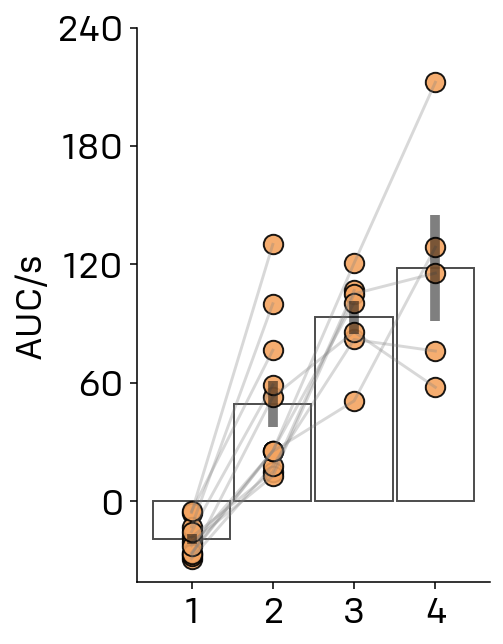

In [559]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def plot_auc_per_second_with_mixedlm(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['1', '2', '3', '4'], 
                                                ['In black', 'In grey', 'In white', 'In last']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Skip conditions where time spent is less than 5 seconds
            if time_spent < 10:
                continue
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)
    print(auc_per_sec_df)
    # Perform a mixed-effects model analysis
    # AUC_per_sec as the dependent variable, Condition as a fixed effect, and ID as a random effect
    model = mixedlm("AUC_per_sec ~ Condition", auc_per_sec_df, groups=auc_per_sec_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())
    
    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(auc_per_sec_df['AUC_per_sec'], auc_per_sec_df['Condition'])
    print(tukey)
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(4,5))

    for mouse in auc_per_sec_df['ID'].unique():
        mouse_data = auc_per_sec_df[auc_per_sec_df['ID'] == mouse]
        plt.scatter(mouse_data['Condition'], mouse_data['AUC_per_sec'], 
                    alpha=0.9, color='sandybrown', edgecolor='black', s=100)
    
    # Add lines connecting individual data points by ID
    for mouse in auc_per_sec_df['ID'].unique():
        mouse_data = auc_per_sec_df[auc_per_sec_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['AUC_per_sec'], 
                 color='grey', alpha=0.3)
    
    # Calculate means and SEM
    means = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].mean()
    sems = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].sem()
    
    # Plot the average AUC per second for each condition with SEM
    plt.bar(means.index, means, yerr=sems, capsize=0, 
        color='none', alpha=0.7, edgecolor='black', label='Mean time spent', 
        width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
        zorder=0)
    
    # Add labels and title
    plt.ylabel('AUC/s')
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 5
    ax.set_ylim(top=240)
    plt.tight_layout()

    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/AUC.pdf', format='pdf')
    plt.show()

    return auc_per_sec_df, mixedlm_results, tukey

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, perform mixed-effects model analysis, and Tukey's post-hoc
auc_per_sec_df, mixedlm_results, tukey_results = plot_auc_per_second_with_mixedlm(df)





      ID Condition  AUC_per_sec sex
0   1034         1   -18.184694   M
1   1034         2     9.244714   M
2   1034         3    79.500578   M
3    129         1    -5.693233   F
4    129         2   130.115030   F
5   1051         1   -20.833311   F
6   1051         2    10.880963   F
7   1051         3    93.861093   F
8   1051         4   107.959426   F
9   1052         1   -29.018499   F
10  1052         2    13.706950   F
11  1052         3    53.881068   F
12  1052         4    70.220149   F
13   116         1   -12.829719   M
14   116         2   100.052324   M
15  1050         1   -27.492229   F
16  1050         2    41.525285   F
17  1050         3    26.740781   F
18  1050         4    35.415955   F
19   118         1    -5.111784   M
20   118         2    76.542873   M
21  1035         1   -26.013767   M
22  1035         2    25.477572   M
23  1035         3    98.418933   M
24  1028         1   -26.614177   M
25  1028         2    23.603759   M
26  1028         3   106.082

trak NOT subset; don't know how to subset; dropped


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    1F     1M   2.4117    1.0 -58.8355  63.6589  False
    1F     2F  67.0073 0.0164   8.6103 125.4042   True
    1F     2M  67.1468 0.0243   5.8995  128.394   True
    1F     3F  77.4414 0.0121  12.1516 142.7312   True
    1F     3M   114.83 0.0004  43.3086 186.3514   True
    1F     4F  105.866 0.0003  40.5762 171.1558   True
    1F     4M 224.1383    0.0 114.8876  333.389   True
    1M     2F  64.5956 0.0334   3.3483 125.8428   True
    1M     2M  64.7351 0.0458   0.7644 128.7057   True
    1M     3F  75.0297 0.0226   7.1786 142.8808   True
    1M     3M 112.4183 0.0008  38.5513 186.2852   True
    1M     4F 103.4543 0.0007  35.6032 171.3054   True
    1M     4M 221.7266    0.0 110.9262  332.527   True
    2F     2M   0.1395    1.0 -61.1077  61.3868  False
    2F     3F  10.4341 0.9994 -54.8556  75.7239  False
    2F    

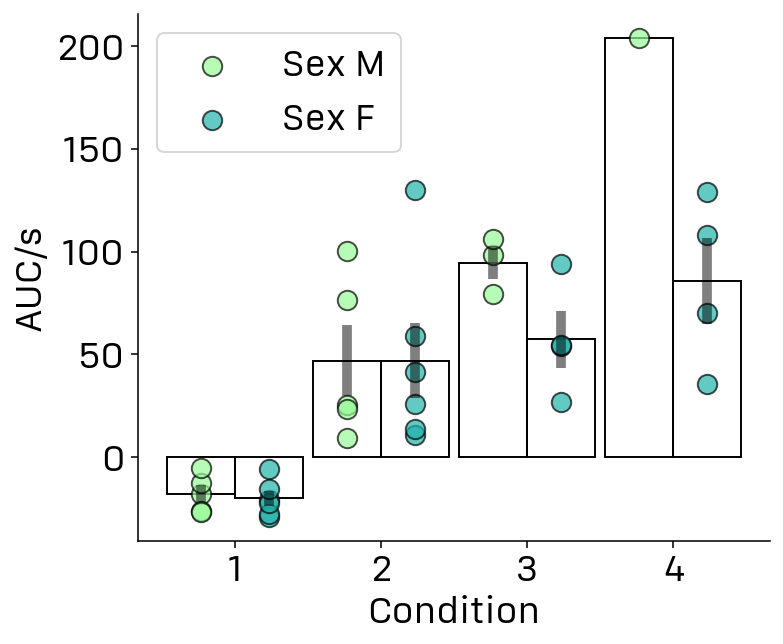

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator

def auc_per_second_with_mixedlm_per_sex(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': [], 'sex': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['1', '2', '3', '4'], 
                                                ['In black', 'In grey', 'In white', 'In last']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Skip conditions where time spent is less than 10 seconds
            if time_spent < 10:
                continue
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
            mouse_auc_values['sex'].append(mouse_data['sex'].iloc[0])
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)
    print(auc_per_sec_df)
    
    # Perform a mixed-effects model analysis
    model = mixedlm("AUC_per_sec ~ Condition * sex", auc_per_sec_df, groups=auc_per_sec_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())
    
    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(auc_per_sec_df['AUC_per_sec'], auc_per_sec_df['Condition'] + auc_per_sec_df['sex'])
    print(tukey)
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(6, 5))

    conditions = ['1', '2', '3', '4']
    sexes = ['M', 'F']
    bar_width = 0.35
    index = np.arange(len(conditions)) * (0.4 + bar_width)  # Adjust spacing between bars

    for i, sex in enumerate(sexes):
        means = auc_per_sec_df[auc_per_sec_df['sex'] == sex].groupby('Condition')['AUC_per_sec'].mean()
        sems = auc_per_sec_df[auc_per_sec_df['sex'] == sex].groupby('Condition')['AUC_per_sec'].sem()
        plt.bar(index + i * bar_width, means, bar_width, yerr=sems, capsize=0, error_kw=dict(lw=5, alpha=0.5, zorder=4), 
                edgecolor='black', color='none')

    # Add individual data points
    for i, sex in enumerate(sexes):
        for condition in conditions:
            condition_data = auc_per_sec_df[(auc_per_sec_df['Condition'] == condition) & (auc_per_sec_df['sex'] == sex)]
            color = 'palegreen' if sex == 'M' else 'lightseagreen'
            plt.scatter(np.repeat(index[conditions.index(condition)] + i * bar_width, len(condition_data)), 
                        condition_data['AUC_per_sec'], alpha=0.7, edgecolor='black', s=100, color=color, label=f'Sex {sex}' if condition == '1' else "")

    plt.xlabel('Condition')
    plt.ylabel('AUC/s')
    plt.xticks(index + bar_width / 2, conditions)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/anxietypaper/figures/sexdifferences/SAMAUC.pdf', format='pdf')
    plt.show()

    return auc_per_sec_df, mixedlm_results, tukey

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, perform mixed-effects model analysis, and Tukey's post-hoc
auc_per_sec_df, mixedlm_results, tukey_results = auc_per_second_with_mixedlm_per_sex(df)


## Behavior

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   time_spent
No. Observations:     44        Method:               REML      
No. Groups:           11        Scale:                2656.0439 
Min. group size:      4         Log-Likelihood:       -219.2454 
Max. group size:      4         Converged:            No        
Mean group size:      4.0                                       
----------------------------------------------------------------
                Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept       439.511   15.539  28.284 0.000  409.055  469.966
Condition[T.2] -316.585   21.975 -14.406 0.000 -359.656 -273.514
Condition[T.3] -415.217   21.975 -18.895 0.000 -458.288 -372.146
Condition[T.4] -426.552   21.975 -19.410 0.000 -469.622 -383.481
Group Var         0.022                                         

   Multiple Comparison of Means - Tuke

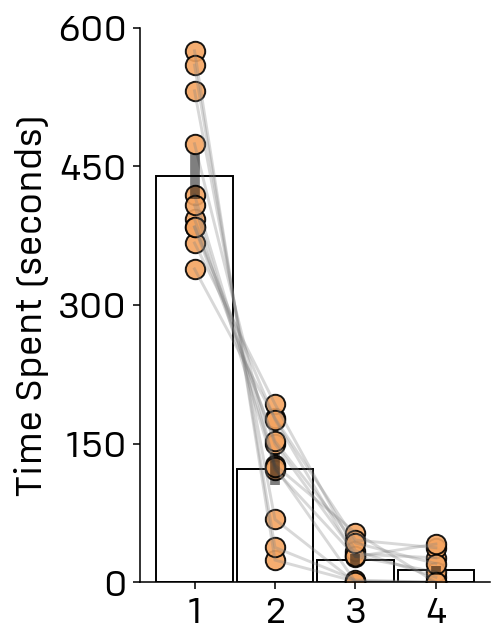

In [561]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_time_spent_in_compartments(df):

    # Dictionary to store individual time spent values for each mouse (for plotting)
    mouse_time_values = {'ID' : [], 'Condition' : [], 'time_spent' : []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate the time spent in seconds
        for condition, condition_column in zip(['1', '2', '3', '4'], 
                                                ['In black', 'In grey', 'In white', 'In last']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            if len(condition_data) == 0:
                # If no time spent in this condition, append 0 for time spent
                time_spent = 0
            else:
                # Calculate the time spent in the condition (in seconds)
                time_spent = len(condition_data) / 60 # Adjust if your time scale is different
                
            # Append the time spent for each condition to the corresponding list
            mouse_time_values['ID'].append(mouse)
            mouse_time_values['Condition'].append(condition)
            mouse_time_values['time_spent'].append(time_spent)

    time_spent_df = pd.DataFrame(mouse_time_values)

    #STATS

    model = mixedlm("time_spent ~ Condition", time_spent_df, groups=time_spent_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    tukey = pairwise_tukeyhsd(time_spent_df['time_spent'], time_spent_df['Condition'])
    print(tukey)
    
    #PLOTTING 

    plt.figure(figsize=(4,5))

    for mouse in time_spent_df['ID'].unique():
        mouse_data = time_spent_df[time_spent_df['ID'] == mouse]
        plt.scatter(mouse_data['Condition'], mouse_data['time_spent'], 
                 alpha=0.9, color='sandybrown', edgecolor='black', s=100)

    # Add lines connecting individual data points by ID
    for mouse in time_spent_df['ID'].unique():
        mouse_data = time_spent_df[time_spent_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['time_spent'], 
                 color='grey', alpha=0.3)
    
    # Calculate means and SEM
    means = time_spent_df.groupby('Condition')['time_spent'].mean()
    sems = time_spent_df.groupby('Condition')['time_spent'].sem()
    
    # Plot the average time spent for each condition with SEM
    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
        label='Mean AUC per second', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
        zorder=0)
    # Add labels and title
    plt.ylabel('Time Spent (seconds)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    #misc 
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
    # ax.set_xlim(-0.55,3-0.5)
    ax.set_ylim(0, 600)
    plt.tight_layout()

    
    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/behavior.pdf', format='pdf')
    plt.show()

    return time_spent_df

# Example usage:
# Call the function to calculate and plot time spent in each compartment for each mouse
time_spent_df = plot_time_spent_in_compartments(df)

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      time_spent
No. Observations:        44           Method:                  REML      
No. Groups:              11           Scale:                   2884.5038 
Min. group size:         4            Log-Likelihood:          -201.3403 
Max. group size:         4            Converged:               No        
Mean group size:         4.0                                             
-------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept                428.894   21.956  19.535 0.000  385.862  471.926
Condition[T.2]          -303.811   31.008  -9.798 0.000 -364.586 -243.036
Condition[T.3]          -404.131   31.008 -13.033 0.000 -464.905 -343.356
Condition[T.4]          -407.922   31.008 -13.155 0.000 

trak NOT subset; don't know how to subset; dropped


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
    1F     1M   23.3556 0.9959  -81.2159   127.927  False
    1F     2F -303.8111    0.0 -403.5161 -204.1061   True
    1F     2M -308.5578    0.0 -413.1293 -203.9863   True
    1F     3F -404.1306    0.0 -503.8356 -304.4256   True
    1F     3M -405.1644    0.0 -509.7359  -300.593   True
    1F     4F -407.9222    0.0 -507.6272 -308.2172   True
    1F     4M -425.5511    0.0 -530.1226 -320.9796   True
    1M     2F -327.1667    0.0 -431.7382 -222.5952   True
    1M     2M -331.9133    0.0 -441.1347  -222.692   True
    1M     3F -427.4861    0.0 -532.0576 -322.9146   True
    1M     3M   -428.52    0.0 -537.7414 -319.2986   True
    1M     4F -431.2778    0.0 -535.8493 -326.7063   True
    1M     4M -448.9067    0.0  -558.128 -339.6853   True
    2F     2M   -4.7467    1.0 -109.3182   99.8248  False
    2F     3F 

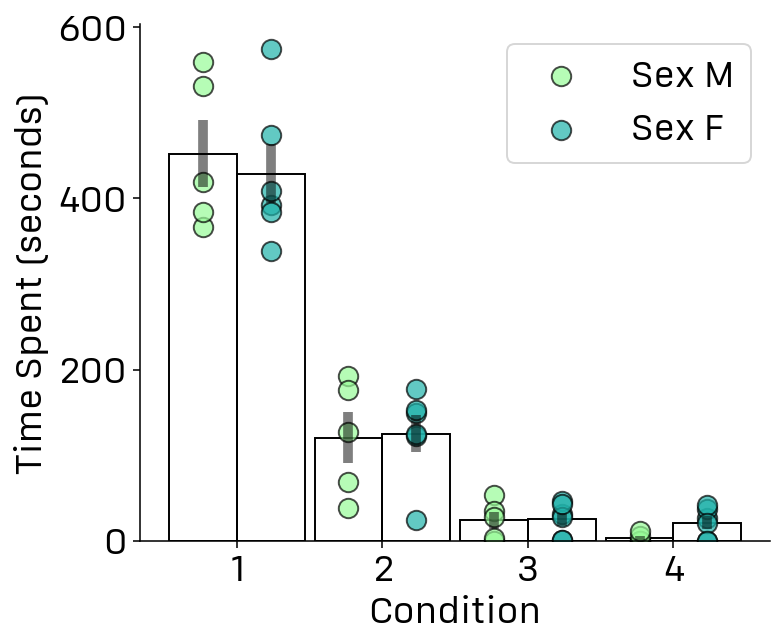

In [620]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator

def plot_time_spent_in_compartments(df):
    # Dictionary to store individual time spent values for each mouse (for plotting)
    mouse_time_values = {'ID': [], 'Condition': [], 'time_spent': [], 'sex': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate the time spent in seconds
        for condition, condition_column in zip(['1', '2', '3', '4'], 
                                                ['In black', 'In grey', 'In white', 'In last']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            if len(condition_data) == 0:
                # If no time spent in this condition, append 0 for time spent
                time_spent = 0
            else:
                # Calculate the time spent in the condition (in seconds)
                time_spent = len(condition_data) / 60 # Adjust if your time scale is different
                
            # Append the time spent for each condition to the corresponding list
            mouse_time_values['ID'].append(mouse)
            mouse_time_values['Condition'].append(condition)
            mouse_time_values['time_spent'].append(time_spent)
            mouse_time_values['sex'].append(mouse_data['sex'].iloc[0])

    time_spent_df = pd.DataFrame(mouse_time_values)

    # STATS
    model = mixedlm("time_spent ~ Condition * sex", time_spent_df, groups=time_spent_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    tukey = pairwise_tukeyhsd(time_spent_df['time_spent'], time_spent_df['Condition'] + time_spent_df['sex'])
    print(tukey)
    
    # PLOTTING
    plt.figure(figsize=(6, 5))

    conditions = ['1', '2', '3', '4']
    sexes = ['M', 'F']
    bar_width = 0.35
    index = np.arange(len(conditions)) * (0.4 + bar_width)  # Adjust spacing between bars

    for i, sex in enumerate(sexes):
        means = time_spent_df[time_spent_df['sex'] == sex].groupby('Condition')['time_spent'].mean()
        sems = time_spent_df[time_spent_df['sex'] == sex].groupby('Condition')['time_spent'].sem()
        plt.bar(index + i * bar_width, means, bar_width, yerr=sems, capsize=0, error_kw=dict(lw=5, alpha=0.5, zorder=4), 
                edgecolor='black', color='none')

    # Add individual data points
    for i, sex in enumerate(sexes):
        for condition in conditions:
            condition_data = time_spent_df[(time_spent_df['Condition'] == condition) & (time_spent_df['sex'] == sex)]
            color = 'palegreen' if sex == 'M' else 'lightseagreen'
            plt.scatter(np.repeat(index[conditions.index(condition)] + i * bar_width, len(condition_data)), 
                        condition_data['time_spent'], alpha=0.7, edgecolor='black', s=100, color=color, label=f'Sex {sex}' if condition == '1' else "")

    plt.xlabel('Condition')
    plt.ylabel('Time Spent (seconds)')
    plt.xticks(index + bar_width / 2, conditions)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/anxietypaper/figures/sexdifferences/SAMbehavior.pdf', format='pdf')
    plt.show()

    return time_spent_df

# Example usage:
# Call the function to calculate and plot time spent in each compartment for each mouse
time_spent_df = plot_time_spent_in_compartments(df)


## SORTING

In [562]:
# #NEW BLACK TO GREY 
# # Parameters
# sampling_rate = 60
# min_closedarms_rows = 5 * sampling_rate  # Convert time to rows
# min_after_rows = 10 * sampling_rate      # Convert time to rows

# # Initialize list to store processed mouse data
# processed_mouse_data = []

# for mouse in df['ID'].unique():
#     # Filter the data for the current mouse
#     mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
    
#     # Create a boolean mask where 'In Closed Arms' is 1 for the current mouse
#     closed_arms_mask = mouse_data['In black'] == 1
    
#     # Identify indices where 'In Closed Arms' transitions from 1 to 0
#     transition_indices = closed_arms_mask[(closed_arms_mask.shift(1) == 1) & (closed_arms_mask == 0)].index

#     # Iterate through transition indices
#     for transition_index in transition_indices:
#         # Define start and end indices for checks
#         preceding_start_index = max(0, transition_index - min_closedarms_rows)
#         following_end_index = min(len(mouse_data), transition_index + min_after_rows)
        
#         # Get preceding and following rows
#         preceding_rows = mouse_data.loc[preceding_start_index:transition_index - 1, 'In black']
#         following_rows = mouse_data.loc[transition_index:following_end_index - 1, 'In black']

        
#         # Check if conditions are satisfied
#         if preceding_rows.eq(1).mean() >= 0.8 and following_rows.eq(0).mean() >= 0.8:  #rule so that 80% of rows must met the condition
#             mouse_data.loc[transition_index, 'valid_transition'] = 1
#         else:
#             print(f"Transition at index {transition_index} for mouse {mouse} skipped due to unmet conditions.")
    
#     # Append the processed mouse data to the list
#     processed_mouse_data.append(mouse_data)

# # Concatenate all processed mouse data into a single DataFrame
# df = pd.concat(processed_mouse_data, ignore_index=True)

# # Display results
# print(df['valid_transition'].value_counts())

In [563]:
#NEW GREY TO WHITE
# Parameters
sampling_rate = 60
min_closedarms_rows = 5 * sampling_rate  # Convert time to rows
min_after_rows = 10 * sampling_rate      # Convert time to rows

# Initialize list to store processed mouse data
processed_mouse_data = []

for mouse in df['ID'].unique():
    # Filter the data for the current mouse
    mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
    
    # Create a boolean mask where 'In Closed Arms' is 1 for the current mouse
    closed_arms_mask = mouse_data['In grey'] == 1
    
    # Identify indices where 'In Closed Arms' transitions from 1 to 0
    transition_indices = closed_arms_mask[(closed_arms_mask.shift(1) == 1) & (closed_arms_mask == 0)].index

    # Iterate through transition indices
    for transition_index in transition_indices:
        # Define start and end indices for checks
        preceding_start_index = max(0, transition_index - min_closedarms_rows)
        following_end_index = min(len(mouse_data), transition_index + min_after_rows)
        
        # Get preceding and following rows
        preceding_rows = mouse_data.loc[preceding_start_index:transition_index - 1, 'In grey']
        following_rows = mouse_data.loc[transition_index:following_end_index - 1, 'In grey']
        following_blackrows = mouse_data.loc[transition_index:following_end_index - 1, 'In black']

        
        # Check if conditions are satisfied
        if preceding_rows.eq(1).mean() >= 0.8 and following_rows.eq(0).mean() >= 0.8 and following_blackrows.eq(0).mean() >= 1  :  #rule so that 80% of rows must met the condition
            mouse_data.loc[transition_index, 'valid_transition'] = 1
        else:
            print(f"Transition at index {transition_index} for mouse {mouse} skipped due to unmet conditions.")
    
    # Append the processed mouse data to the list
    processed_mouse_data.append(mouse_data)

# Concatenate all processed mouse data into a single DataFrame
df = pd.concat(processed_mouse_data, ignore_index=True)

# Display results
print(df['valid_transition'].value_counts())

Transition at index 1050 for mouse 1034 skipped due to unmet conditions.
Transition at index 4122 for mouse 1034 skipped due to unmet conditions.
Transition at index 4410 for mouse 1034 skipped due to unmet conditions.
Transition at index 12907 for mouse 1034 skipped due to unmet conditions.
Transition at index 14564 for mouse 1034 skipped due to unmet conditions.
Transition at index 16733 for mouse 1034 skipped due to unmet conditions.
Transition at index 19773 for mouse 1034 skipped due to unmet conditions.
Transition at index 25202 for mouse 1034 skipped due to unmet conditions.
Transition at index 26309 for mouse 1034 skipped due to unmet conditions.
Transition at index 26929 for mouse 1034 skipped due to unmet conditions.
Transition at index 30184 for mouse 1034 skipped due to unmet conditions.
Transition at index 30898 for mouse 1034 skipped due to unmet conditions.
Transition at index 35394 for mouse 1034 skipped due to unmet conditions.
Transition at index 8569 for mouse 129 sk

## analysis

In [564]:
# Pre-tone and post-tone window settings
pre_tone = -5
post_tone = 10
sampling_freq = 60

presample = int(abs(pre_tone * sampling_freq))  # Number of samples before the tone
postsample = int(abs(post_tone * sampling_freq))  # Number of samples after the tone

total_samples = presample + postsample + 1  # Total samples from -3 to 5 seconds

# Create empty list to store processed dataframes
processed_dfs = []

# Iterate through each mouse
for mouse in df['ID'].unique():
    # Filter for the current mouse
    mousedf = df[df['ID'] == mouse].reset_index(drop=True)

    # Identify onset indices of valid transitions
    onset_indices = mousedf[mousedf['valid_transition'] == 1].index

    # Loop through each valid transition
    for t, onset in enumerate(onset_indices):
        # Define start and end indices for the time vector
        start_idx = onset - presample
        end_idx = onset + postsample

        # Ensure indices stay within bounds and length matches total_samples
        if start_idx >= 0 and end_idx < len(mousedf) and (end_idx - start_idx + 1) == total_samples:
            # Generate the time vector
            time_vector = np.linspace(pre_tone, post_tone, total_samples)

            # Assign the time vector and exploration number
            mousedf.loc[start_idx:end_idx, 'time_vector'] = time_vector
            mousedf.loc[start_idx:end_idx, 'exploration'] = 1
            mousedf.loc[start_idx:end_idx, 'explorationnumber'] = t + 1  # Start from 1
        else:
            print(f"Transition {t + 1} for mouse {mouse} skipped due to boundary conditions.")

    # Append the processed mouse DataFrame to the list
    processed_dfs.append(mousedf)

# Concatenate all processed DataFrames
df = pd.concat(processed_dfs, ignore_index=True)

# Display the updated DataFrame
print(df['explorationnumber'].unique())


Transition 6 for mouse 1052 skipped due to boundary conditions.
[nan  1.  2.  3.  4.  5.]


In [565]:
# Normalize Zscoreg for each exploration number for each mouse
for mouse_id in df['ID'].unique():
    # Filter for the current mouse
    mouse_data = df[df['ID'] == mouse_id]
    
    # Loop through each exploration number for the current mouse
    for explo_num in mouse_data['explorationnumber'].unique():
        # Filter for the current exploration number
        explo_data = mouse_data[mouse_data['explorationnumber'] == explo_num]
        
        # Identify pre-event period (before exploration, i.e., before time_vector = 0)
        pre_event_data = explo_data[explo_data['time_vector'] < 0]
        
        # Compute the mean Z-score for the pre-event period
        pre_event_mean = pre_event_data['Zscoreg'].mean()
        
        # Normalize the Zscoreg by subtracting the pre-event mean
        df.loc[explo_data.index, 'Zscoreg'] -= pre_event_mean

# Now `df['Zscoreg']` will be normalized for each exploration number for each mouse
print(df)


              Time   Zscoreg   Zscorer  In black  In grey  In white  In last  \
0         0.097857  0.216460  0.023744         1        0         0        0   
1         0.114533  0.216460  0.023744         1        0         0        0   
2         0.131209  0.216460  0.023744         1        0         0        0   
3         0.147885  0.216460  0.023744         1        0         0        0   
4         0.164561  0.216460  0.023744         1        0         0        0   
...            ...       ...       ...       ...      ...       ...      ...   
395925  600.129720 -0.189154 -1.527112         0        0         0        0   
395926  600.146394 -0.179611 -1.117805         0        0         0        0   
395927  600.163068 -0.169429 -0.485170         0        0         0        0   
395928  600.179741 -0.158609  0.598385         0        0         0        0   
395929  600.196415 -0.147151  2.052659         0        0         0        0   

          ID sex  valid_transition  tim

In [566]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_peth(df):
#     # List to store the PETH for each mouse, separately for males and females
#     male_average = []
#     female_average = []
    
#     # Loop through each mouse
#     for mouse in df['ID'].unique():
#         # Filter the data for the current mouse
#         mouse_data = df[df['ID'] == mouse]
        
#         # Group by 'time_vector' and calculate the mean Z-score for each time point
#         zscore_grouped = mouse_data.groupby('time_vector')['Zscoreg'].mean()
        
#         # Plot individual mouse PETH (gray trace)
#         plt.plot(zscore_grouped.index, zscore_grouped, alpha=0.5, color='gray')
        
#         # Append to the appropriate list based on sex
#         if mouse_data['sex'].iloc[0] == 'M':  # If the mouse is male
#             male_average.append(zscore_grouped)
#         else:  # If the mouse is female
#             female_average.append(zscore_grouped)
    
#     # Convert list of individual averages into DataFrames
#     male_average_df = pd.DataFrame(male_average)
#     female_average_df = pd.DataFrame(female_average)
    
#     # Calculate the mean and SEM across all males
#     mean_males = male_average_df.mean(axis=0)
#     sem_males = male_average_df.sem(axis=0)
    
#     # Calculate the mean and SEM across all females
#     mean_females = female_average_df.mean(axis=0)
#     sem_females = female_average_df.sem(axis=0)
    
#     # Plot the mean PETH for males and females with SEM
#     plt.plot(mean_males.index, mean_males, color='blue', linewidth=2, label='Male Average')
#     plt.fill_between(mean_males.index, mean_males - sem_males, 
#                      mean_males + sem_males, color='blue', alpha=0.3, label='Male SEM')
    
#     plt.plot(mean_females.index, mean_females, color='red', linewidth=2, label='Female Average')
#     plt.fill_between(mean_females.index, mean_females - sem_females, 
#                      mean_females + sem_females, color='red', alpha=0.3, label='Female SEM')
    
#     # Add labels and title
#     plt.xlabel('Time (s)')
#     plt.ylabel('Zscore')
#     plt.title('Zscored GCaMP8f signal aligned on closed to open transition')
#     plt.axhline(y=0, color='black', linestyle='--')
#     plt.ylim(-0.5, 2)
    
#     # Show the plot
#     plt.legend()
#     plt.show()

#     return male_average_df, female_average_df

# # Example usage:
# # Call the function to plot PETH for each mouse and the average across all mice, separated by sex
# male_avg_df, female_avg_df = plot_peth(df)


trak NOT subset; don't know how to subset; dropped


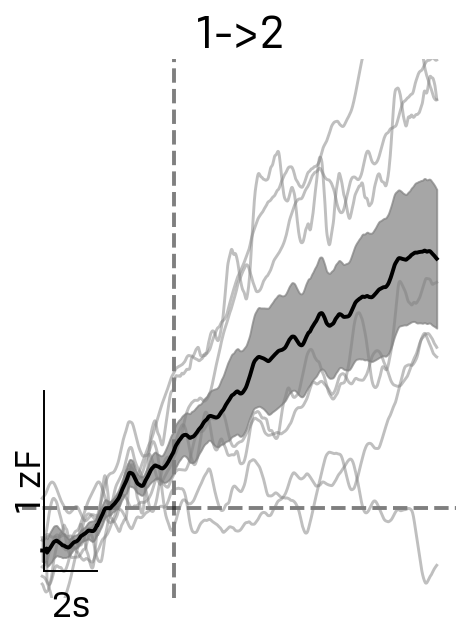

time_vector,-5.000000,-4.983333,-4.966667,-4.950000,-4.933333,-4.916667,-4.900000,-4.883333,-4.866667,-4.850000,...,9.850000,9.866667,9.883333,9.900000,9.916667,9.933333,9.950000,9.966667,9.983333,10.000000
Zscoreg,-0.178874,-0.174771,-0.170590,-0.166355,-0.162220,-0.158379,-0.155076,-0.152516,-0.150652,-0.149164,...,0.868119,0.862608,0.858730,0.856115,0.853886,0.851298,0.848235,0.845202,0.842845,0.841489
Zscoreg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zscoreg,-0.422370,-0.425222,-0.430004,-0.437541,-0.445501,-0.451866,-0.456955,-0.461732,-0.465526,-0.466806,...,2.393684,2.389384,2.382024,2.372999,2.362910,2.350668,2.334974,2.316130,2.296158,2.277321
Zscoreg,-0.234079,-0.233034,-0.232021,-0.230877,-0.229469,-0.227739,-0.225782,-0.223912,-0.222602,-0.222288,...,0.936802,0.931107,0.924998,0.919237,0.914451,0.910686,0.907422,0.903977,0.899902,0.895149
Zscoreg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zscoreg,0.055037,0.058420,0.061720,0.064654,0.067200,0.069617,0.072340,0.075813,0.080317,0.085852,...,-0.354131,-0.348989,-0.344218,-0.339826,-0.335741,-0.331893,-0.328230,-0.324727,-0.321381,-0.318185
Zscoreg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zscoreg,-0.327115,-0.324197,-0.321749,-0.320222,-0.319210,-0.317981,-0.316098,-0.313517,-0.310174,-0.305674,...,2.505681,2.504999,2.503681,2.501743,2.499229,2.496439,2.494062,2.492822,2.493002,2.494474
Zscoreg,-0.379140,-0.380874,-0.381645,-0.382253,-0.383620,-0.386046,-0.389180,-0.392717,-0.396618,-0.400638,...,2.301683,2.293918,2.287639,2.282749,2.278883,2.275728,2.273225,2.271574,2.271107,2.272176
Zscoreg,-0.163964,-0.172579,-0.178540,-0.180729,-0.178591,-0.172387,-0.163403,-0.153546,-0.144140,-0.134894,...,1.245504,1.247128,1.249236,1.250844,1.251770,1.252342,1.252959,1.253848,1.255125,1.256918


In [567]:
def plot_peth(df):
    
    plt.figure(figsize=(4,5))
    # List to store the PETH for each mouse
    mouse_average = []
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # Group by 'time_vector' and calculate the mean Z-score for each time point
        zscore_grouped = mouse_data.groupby('time_vector')['Zscoreg'].mean()
        
        # Plot individual mouse PETH (gray trace)
        plt.plot(zscore_grouped.index, zscore_grouped, alpha=0.5, color='gray')
        
        # Append to the list of mouse averages
        mouse_average.append(zscore_grouped)
    
    # Convert list of individual averages into a DataFrame
    mouse_average_df = pd.DataFrame(mouse_average)
    
    # Calculate the mean and SEM across all mice
    mean_across_mice = mouse_average_df.mean(axis=0)
    sem_across_mice = mouse_average_df.sem(axis=0)
    
    # Plot the mean across all mice with SEM
    plt.plot(mean_across_mice.index, mean_across_mice, color='black', linewidth=2, label='Mean Across Mice')
    plt.fill_between(mean_across_mice.index, mean_across_mice - sem_across_mice, 
                     mean_across_mice + sem_across_mice, color='gray', alpha=0.7, label='SEM')
    
    plt.axvline(x=0, color='black', linestyle='--', linewidth=2, zorder=0, alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, zorder=0, alpha=0.5)
    
    # Add labels and title
    plt.title('1->2')


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)


    #drop the y axis
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)

    plt.ylim(-.5, 2.5)
    y_min, y_max = plt.gca().get_ylim()  # Get current y-axis limits
    x_min, x_max = plt.gca().get_xlim()  # Get current x-axis limits
    scale_x_pos = x_min + (x_max - x_min) * 0.05  # Position to the left of the plot
    scale_y_pos = y_min + (y_max - y_min) * 0.05  # Position near the bottom of the plot

    plt.plot([scale_x_pos, scale_x_pos], [scale_y_pos, scale_y_pos + 1], color='black', linewidth=1)
    plt.text(scale_x_pos - 0.5, scale_y_pos + 0.5, '1 zF', ha='center', va='center', rotation='vertical')

    plt.plot([scale_x_pos, scale_x_pos + 2], [scale_y_pos, scale_y_pos], color='black', linewidth=1)  # Horizontal line at y=0
    plt.text(scale_x_pos + 1, scale_y_pos - 0.1, '2s', ha='center', va='top')

    
    # Show the plot
    plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/figures/2to3.pdf', format='pdf')
    plt.show()

    return mouse_average_df

# Example usage:
# Call the function to plot PETH for each mouse and the average across all mice
plot_peth(df)


In [568]:

# # Iterate through each mouse
# for mouse, mouse_df in df.groupby('ID'):
#     # Iterate through each explorationnumber for the current mouse
#     for exploration, group in mouse_df.groupby('explorationnumber'):
#         # Skip exploration numbers with no data (e.g., explorationnumber == 0)
#         if exploration == 0:
#             continue
        
#         # Plot Zscoreg vs time_vector
#         plt.figure(figsize=(8, 5))
#         plt.plot(group['time_vector'], group['Zscoreg'], label=f"Exploration {exploration}")
        
#         # Add plot details
#         plt.title(f"Mouse: {mouse} | Exploration: {exploration}")
#         plt.xlabel('Time (s)')
#         plt.ylabel('Z-score (Zscoreg)')
#         plt.axvline(0, color='red', linestyle='--', label='Tone Onset')  # Indicate tone onset
#         plt.legend()
#         plt.grid()

#         # Show plot
#         plt.show()


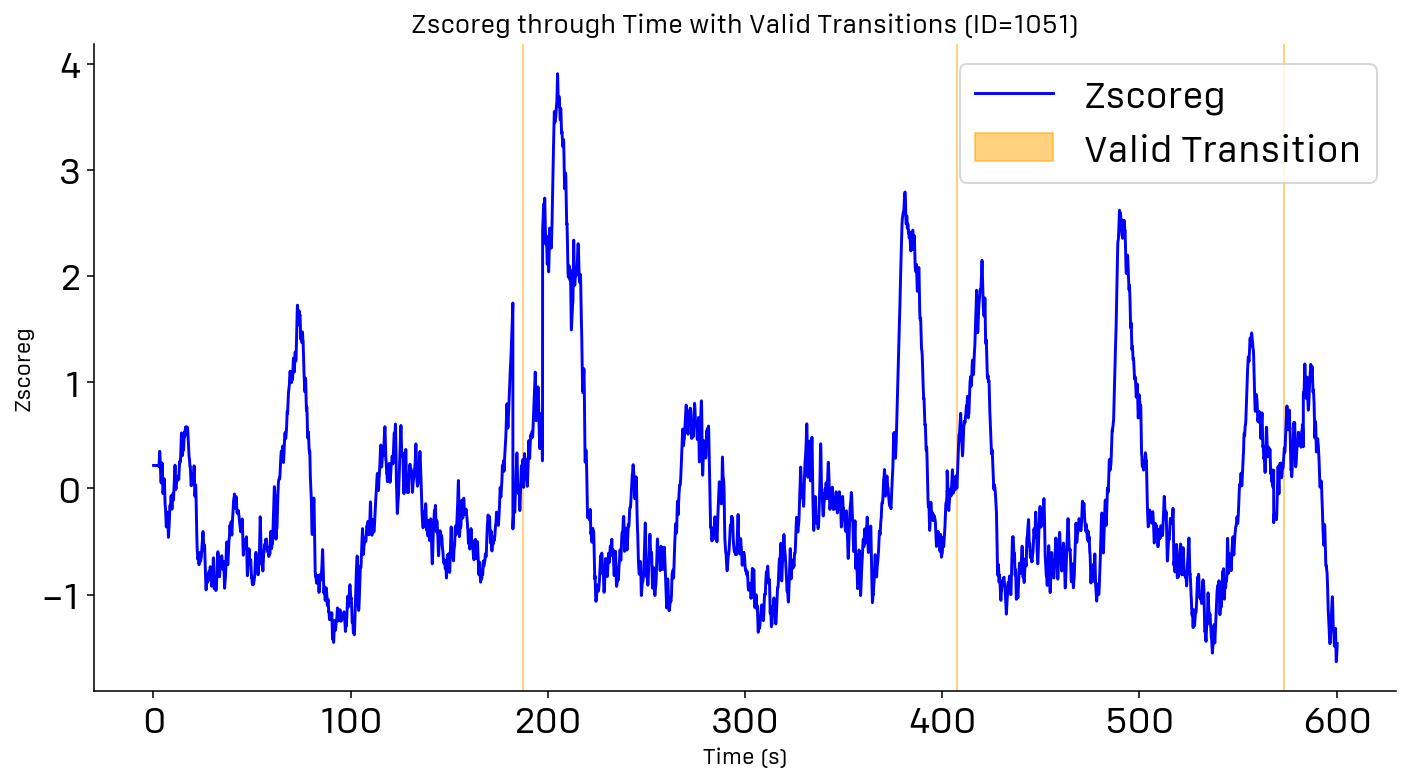

In [569]:

# Filter the DataFrame for ID=1051
df_1051 = df[df['ID'] == 1034]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Zscoreg through Time
plt.plot(df_1051['Time'], df_1051['Zscoreg'], label='Zscoreg', color='blue', linewidth=1.5)

# Highlight valid transitions as bars
for _, row in df_1051[df_1051['valid_transition'] == 1].iterrows():
    plt.axvspan(row['Time'], row['Time'], color='orange', alpha=0.5, label='Valid Transition')

# Add labels and title
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Zscoreg', fontsize=12)
plt.title('Zscoreg through Time with Valid Transitions (ID=1051)', fontsize=14)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(by_label.values(), by_label.keys())
# plt.xlim(180, 240)

# Display the plot
plt.show()


In [570]:

# # Set the minimum event duration in seconds (e.g., 10 seconds)
# min_duration = 10

# # Create a boolean mask where 'In middle' is 1 (event occurs)
# event_mask = df['In middle'] == 1

# # Identify the indices where the event starts (transition from 0 to 1)
# start_indices = event_mask[(event_mask.shift(1) == 0) & (event_mask == 1)].index

# # Identify the indices where the event ends (transition from 1 to 0)
# end_indices = event_mask[(event_mask.shift(-1) == 0) & (event_mask == 1)].index

# # Ensure we have matching start and end indices
# if len(start_indices) != len(end_indices):
#     raise ValueError("Mismatch between start and end events")

# # Create a new column 'longmiddle' to store the result
# df['longmiddle'] = 0  # Default value is 0, meaning the event is not long enough

# # For each event, check the duration and recode 'longmiddle' as 1 if duration > min_duration
# for start, end in zip(start_indices, end_indices):
#     event_duration = df.loc[end, 'Time'] - df.loc[start, 'Time']
    
#     # If event duration is more than the threshold, set 'longmiddle' to 1
#     if event_duration >= min_duration:
#         df.loc[start:end, 'longmiddle'] = 1

# # Display the updated DataFrame
# print(df)
